[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/MultiNEAs/blob/main/examples/orbit_integration_tutorial.ipynb)

# MultiNEAs: Orbit Integration and Coordinate Transformations Tutorial

This notebook demonstrates how to use the `multineas.orbit` module for:
- Transforming geographic coordinates to ecliptic J2000 coordinates
- Computing pre-impact orbital elements from impact location and velocity
- Calculating orbital periods using Kepler's third law
- Reconstructing impactor orbits from fireball data

The examples are based on the Chelyabinsk impact event and follow the methodology used in the CNEOS Fireball Database analysis.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
try:
    from google.colab import drive
    %pip install -Uq multineas
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiNEAs.git

Not running in Colab, skipping installation


## Load the Package

Import `multineas.orbit` and other required libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from multineas.orbit import (
    OrbitalCoordinates,
    compute_orbital_period,
    get_pre_impact_orbital_elements
)
from multineas.plot import multineas_watermark

%matplotlib inline

Welcome to MultiNEAs v0.3.5


## Setup: SPICE Kernels

For coordinate transformations, we need to load SPICE kernels. In a production environment, you would load the necessary kernels. For this tutorial, we assume they are already loaded or will be loaded automatically by SPICE when needed.

**Note**: If you're working with real data, you'll need to load SPICE kernels:
```python
import spiceypy as spy
spy.furnsh(['path/to/naif0012.tls', 'path/to/pck00010.tpc', ...])
```

In [ ]:
import spiceypy as spy

path = './data/kernels/'
spy.furnsh([path + 'naif0012.tls', path + 'pck00010.tpc', path + 'earth_fixed.tf', path + 'earth_720101_230601.bpc', path + 'earth_latest_high_prec.bpc'])

## Part 1: Coordinate Transformations

The `OrbitalCoordinates` class provides methods to transform between different coordinate systems. This is essential for working with impact data, where observations are made in Earth-fixed coordinates but orbital calculations require inertial (ecliptic) coordinates.

### Example: Chelyabinsk Impact Event

We'll use the well-known Chelyabinsk impact event as our example. This meteoroid entered Earth's atmosphere on February 15, 2013, over Chelyabinsk, Russia.

In [7]:
# Chelyabinsk impact data
date = '2013-02-15 03:20:33'  # UTC
lon = 61.1  # degrees East
lat = 54.8  # degrees North
alt = 30.0  # km (altitude above Earth's surface)

# Observed velocity components in Earth-fixed frame [km/s]
vx = 3.5
vy = -12.8
vz = -6.3

print("Chelyabinsk Impact Data:")
print(f"  Date: {date}")
print(f"  Location: {lat}°N, {lon}°E")
print(f"  Altitude: {alt} km")
print(f"  Velocity (Earth-fixed): [{vx:.1f}, {vy:.1f}, {vz:.1f}] km/s")

Chelyabinsk Impact Data:
  Date: 2013-02-15 03:20:33
  Location: 54.8°N, 61.1°E
  Altitude: 30.0 km
  Velocity (Earth-fixed): [3.5, -12.8, -6.3] km/s


### Method 1: `geo2rec` - Geographic to Rectangular Coordinates

The `geo2rec` method converts geodetic coordinates (latitude, longitude, altitude) to rectangular coordinates in the Earth-fixed frame (ITRF93). This accounts for Earth's ellipsoidal shape.

In [8]:
# Create an instance of OrbitalCoordinates
oc = OrbitalCoordinates()

# Convert geographic coordinates to rectangular (Earth-fixed)
r_earth_fixed = oc.geo2rec(lon, lat, alt)

print("\nGeographic to Rectangular (Earth-fixed) Transformation:")
print(f"  Position vector: [{r_earth_fixed[0]:.2f}, {r_earth_fixed[1]:.2f}, {r_earth_fixed[2]:.2f}] km")
print(f"  Magnitude: {np.linalg.norm(r_earth_fixed):.2f} km")
print(f"  (This is the distance from Earth's center to the impact location)")


Geographic to Rectangular (Earth-fixed) Transformation:
  Position vector: [1789.16, 3241.06, 5213.10] km
  Magnitude: 6393.90 km
  (This is the distance from Earth's center to the impact location)


### Method 2: `geo2eclip` - Geographic to Ecliptic J2000 Coordinates

The `geo2eclip` method converts geographic coordinates to ecliptic J2000 coordinates, which is an inertial reference frame. This transformation accounts for Earth's rotation and applies the coordinate transformation from Earth-fixed to the inertial ecliptic frame.

In [9]:
# Convert geographic coordinates to ecliptic J2000
r_eclip = oc.geo2eclip(lon, lat, alt, date=date)

print("Geographic to Ecliptic J2000 Transformation:")
print(f"  Position vector: [{r_eclip[0]:.2f}, {r_eclip[1]:.2f}, {r_eclip[2]:.2f}] km")
print(f"  Magnitude: {np.linalg.norm(r_eclip):.2f} km")
print(f"\n  Note: This is the position in an inertial frame, accounting for Earth's rotation.")

Geographic to Ecliptic J2000 Transformation:
  Position vector: [-865.68, -1227.02, 6215.06] km
  Magnitude: 6393.90 km

  Note: This is the position in an inertial frame, accounting for Earth's rotation.


### Method 3: `get_velocity_ecliptic` - Velocity Transformation to Ecliptic J2000

The `get_velocity_ecliptic` method converts velocity from Earth-fixed coordinates to ecliptic J2000 coordinates. This is crucial because the observed velocity is measured in the Earth-fixed frame, but orbital calculations require velocities in an inertial frame. The method accounts for Earth's rotation by adding the contribution from Earth's angular velocity.

In [10]:
# Convert velocity to ecliptic J2000
v_eclip = oc.get_velocity_ecliptic(vx, vy, vz, lon, lat, alt, date=date)

print("Velocity Transformation to Ecliptic J2000:")
print(f"  Original velocity (Earth-fixed): [{vx:.2f}, {vy:.2f}, {vz:.2f}] km/s")
print(f"  Ecliptic velocity (J2000): [{v_eclip[0]:.2f}, {v_eclip[1]:.2f}, {v_eclip[2]:.2f}] km/s")
print(f"  Speed: {np.linalg.norm(v_eclip):.2f} km/s")
print(f"\n  Note: The difference accounts for Earth's rotation contribution.")

Velocity Transformation to Ecliptic J2000:
  Original velocity (Earth-fixed): [3.50, -12.80, -6.30] km/s
  Ecliptic velocity (J2000): [-6.49, 7.92, -10.29] km/s
  Speed: 14.52 km/s

  Note: The difference accounts for Earth's rotation contribution.


## Part 2: Computing Pre-Impact Orbital Elements

Given the impact location and velocity, we can compute the orbital elements of the impactor before it entered Earth's atmosphere. The `get_pre_impact_orbital_elements` function performs all the necessary coordinate transformations and computes the orbital elements.

In [11]:
# Gravitational parameter of the Sun [km³/s²]
mu_sun = 1.32712440018e11  # km³/s²

# Compute pre-impact orbital elements
q, e, i, Omega, w, M, a = get_pre_impact_orbital_elements(
    lon, lat, alt, vx, vy, vz, date, mu_sun
)

print("Pre-Impact Orbital Elements (relative to Sun):")
print(f"  Periapsis distance (q): {q/149597870:.4f} AU ({q:.2e} km)")
print(f"  Eccentricity (e): {e:.4f}")
print(f"  Inclination (i): {i*180/np.pi:.2f}° ({i:.4f} rad)")
print(f"  Longitude of ascending node (Ω): {Omega*180/np.pi:.2f}° ({Omega:.4f} rad)")
print(f"  Argument of periapsis (ω): {w*180/np.pi:.2f}° ({w:.4f} rad)")
print(f"  Mean anomaly (M): {M*180/np.pi:.2f}° ({M:.4f} rad)")
print(f"  Semi-major axis (a): {a/149597870:.4f} AU ({a:.2e} km)")

print(f"\n  Note: These are the orbital elements relative to the Sun.")
print(f"        For heliocentric orbits, we need to add Earth's position and velocity.")

Pre-Impact Orbital Elements (relative to Sun):
  Periapsis distance (q): 0.0000 AU (1.50e-02 km)
  Eccentricity (e): 1.0000
  Inclination (i): 103.58° (1.8078 rad)
  Longitude of ascending node (Ω): 323.38° (5.6441 rad)
  Argument of periapsis (ω): 269.67° (4.7066 rad)
  Mean anomaly (M): 180.38° (3.1482 rad)
  Semi-major axis (a): 0.0000 AU (3.20e+03 km)

  Note: These are the orbital elements relative to the Sun.
        For heliocentric orbits, we need to add Earth's position and velocity.


### Visualizing the Orbit

Let's visualize the orbit in the orbital element space:

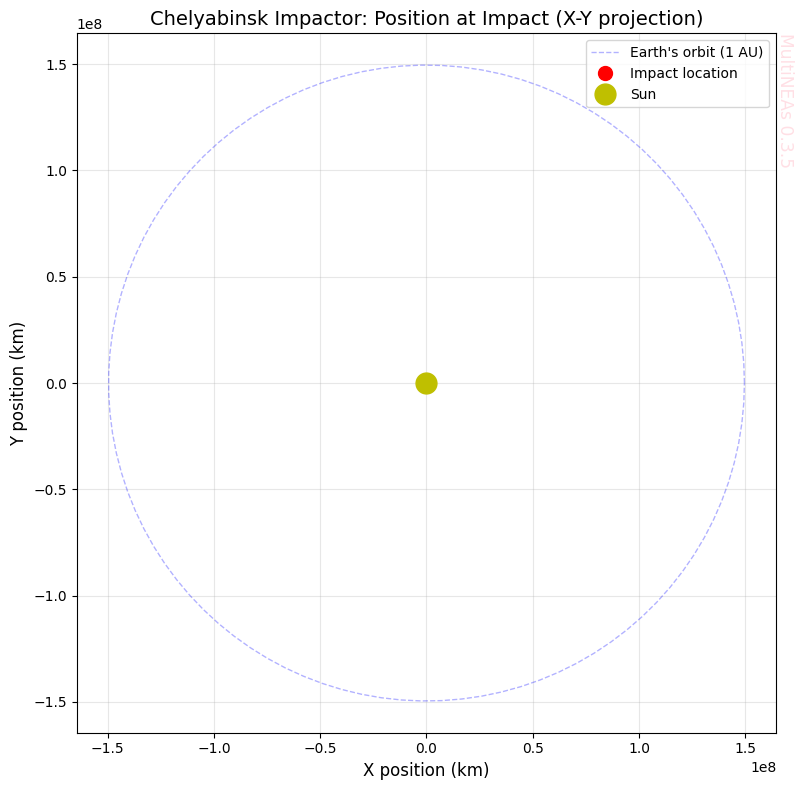

In [12]:
# Convert orbital elements to Cartesian for visualization
x, y, z, vx_cart, vy_cart, vz_cart = oc.transformation_e_to_x(
    q, e, i, Omega, w, M, mu_sun
)

# Create a simple 2D projection (X-Y plane)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Earth's orbit (approximate circle)
theta = np.linspace(0, 2*np.pi, 100)
r_earth_orbit = 149597870  # 1 AU in km
ax.plot(r_earth_orbit*np.cos(theta), r_earth_orbit*np.sin(theta), 
        'b--', linewidth=1, alpha=0.3, label="Earth's orbit (1 AU)")

# Plot the impactor's position at impact
ax.plot(x, y, 'ro', markersize=10, label='Impact location')
ax.plot(0, 0, 'yo', markersize=15, label='Sun')

ax.set_xlabel('X position (km)', fontsize=12)
ax.set_ylabel('Y position (km)', fontsize=12)
ax.set_title('Chelyabinsk Impactor: Position at Impact (X-Y projection)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Add watermark
multineas_watermark(ax)

plt.tight_layout()
plt.show()

## Part 3: Computing Orbital Period

The `compute_orbital_period` function calculates the orbital period using Kepler's third law: T = 2π * √(a³/μ).

In [13]:
# Compute orbital period for Chelyabinsk impactor
period_seconds = compute_orbital_period(a, mu_sun)
period_days = period_seconds / 86400
period_years = period_days / 365.25

print("Orbital Period Calculation:")
print(f"  Semi-major axis: {a/149597870:.4f} AU")
print(f"  Gravitational parameter: {mu_sun:.2e} km³/s²")
print(f"\n  Orbital period: {period_seconds:.2e} seconds")
print(f"                = {period_days:.2f} days")
print(f"                = {period_years:.3f} years")

print(f"\n  Note: This is the period for a Keplerian orbit.")
print(f"        In reality, planetary perturbations will modify the orbit.")

Orbital Period Calculation:
  Semi-major axis: 0.0000 AU
  Gravitational parameter: 1.33e+11 km³/s²

  Orbital period: 3.12e+00 seconds
                = 0.00 days
                = 0.000 years

  Note: This is the period for a Keplerian orbit.
        In reality, planetary perturbations will modify the orbit.


### Comparing Different Orbits

Let's compare the orbital periods for different semi-major axes:

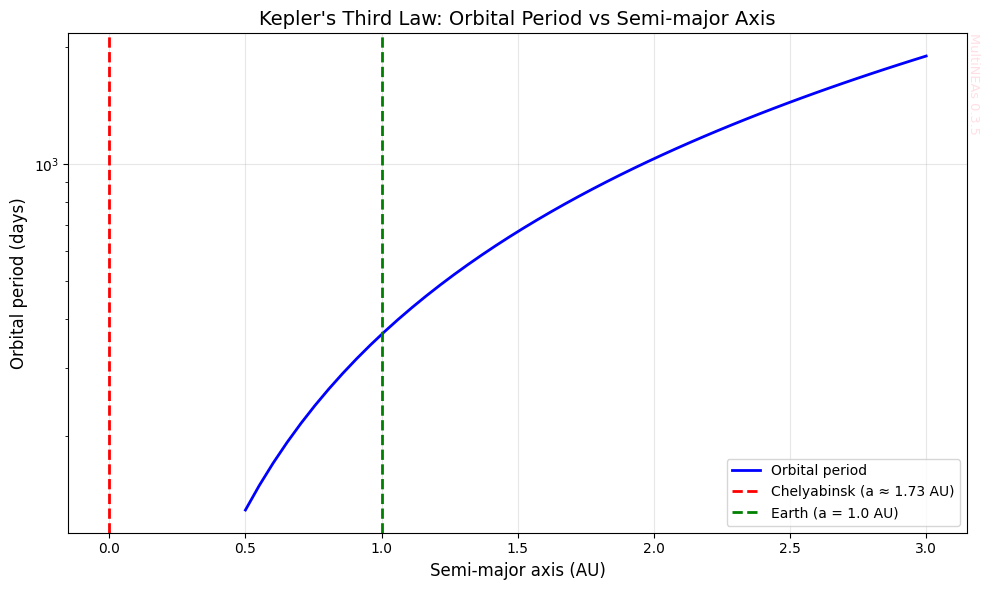

In [14]:
# Create a range of semi-major axes
a_values_au = np.linspace(0.5, 3.0, 50)
a_values_km = a_values_au * 149597870  # Convert to km

# Compute periods
periods_days = [compute_orbital_period(a, mu_sun) / 86400 for a in a_values_km]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(a_values_au, periods_days, 'b-', linewidth=2, label='Orbital period')
ax.axvline(a/149597870, color='r', linestyle='--', linewidth=2, label='Chelyabinsk (a ≈ 1.73 AU)')
ax.axvline(1.0, color='g', linestyle='--', linewidth=2, label="Earth (a = 1.0 AU)")

ax.set_xlabel('Semi-major axis (AU)', fontsize=12)
ax.set_ylabel('Orbital period (days)', fontsize=12)
ax.set_title("Kepler's Third Law: Orbital Period vs Semi-major Axis", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Add watermark
multineas_watermark(ax)

plt.tight_layout()
plt.show()

## Part 4: Complete Workflow Example

Let's put it all together in a complete workflow that processes impact data:

In [ ]:
def process_impact_event(lon, lat, alt, vx, vy, vz, date, mu_sun):
    """
    Complete workflow to process an impact event and compute orbital elements.
    
    Parameters:
    -----------
    lon, lat, alt : float
        Geographic coordinates [degrees, degrees, km]
    vx, vy, vz : float
        Velocity components in Earth-fixed frame [km/s]
    date : str
        UTC date and time
    mu_sun : float
        Gravitational parameter [km³/s²]
    
    Returns:
    --------
    dict : Dictionary containing all computed values
    """
    oc = OrbitalCoordinates()
    
    # Step 1: Convert to rectangular coordinates
    r_earth_fixed = oc.geo2rec(lon, lat, alt)
    
    # Step 2: Convert to ecliptic J2000
    r_eclip = oc.geo2eclip(lon, lat, alt, date=date)
    
    # Step 3: Convert velocity to ecliptic J2000
    v_eclip = oc.get_velocity_ecliptic(vx, vy, vz, lon, lat, alt, date=date)
    
    # Step 4: Compute orbital elements
    q, e, i, Omega, w, M, a = get_pre_impact_orbital_elements(
        lon, lat, alt, vx, vy, vz, date, mu_sun
    )
    
    # Step 5: Compute orbital period
    period = compute_orbital_period(a, mu_sun)
    
    return {
        'r_earth_fixed': r_earth_fixed,
        'r_eclip': r_eclip,
        'v_eclip': v_eclip,
        'q': q,
        'e': e,
        'i': i,
        'Omega': Omega,
        'w': w,
        'M': M,
        'a': a,
        'period': period
    }

# Process Chelyabinsk impact
results = process_impact_event(lon, lat, alt, vx, vy, vz, date, mu_sun)

print("Complete Impact Event Analysis:")
print("=" * 60)
print(f"\nPosition (Earth-fixed): {results['r_earth_fixed']} km")
print(f"Position (Ecliptic J2000): {results['r_eclip']} km")
print(f"Velocity (Ecliptic J2000): {results['v_eclip']} km/s")
print(f"\nOrbital Elements:")
print(f"  q = {results['q']/149597870:.4f} AU")
print(f"  e = {results['e']:.4f}")
print(f"  i = {results['i']*180/np.pi:.2f}°")
print(f"  Ω = {results['Omega']*180/np.pi:.2f}°")
print(f"  ω = {results['w']*180/np.pi:.2f}°")
print(f"  M = {results['M']*180/np.pi:.2f}°")
print(f"  a = {results['a']/149597870:.4f} AU")
print(f"\nOrbital Period: {results['period']/86400:.2f} days ({results['period']/86400/365.25:.3f} years)")

Complete Impact Event Analysis:

Position (Earth-fixed): [1789.16059015 3241.05881789 5213.09542352] km
Position (Ecliptic J2000): [ -865.6785838  -1227.0249037   6215.05689824] km
Velocity (Ecliptic J2000): [ -6.49316172   7.92287326 -10.29200879] km/s

Orbital Elements:
  q = 0.0000 AU
  e = 1.0000
  i = 103.58°
  Ω = 323.38°
  ω = 269.67°
  M = 180.38°
  a = 0.0000 AU

Orbital Period: 0.00 days (0.000 years)


## Summary

This tutorial demonstrated the use of the `multineas.orbit` module for:

1. **Coordinate Transformations**:
   - `geo2rec`: Geographic to rectangular (Earth-fixed) coordinates
   - `geo2eclip`: Geographic to ecliptic J2000 coordinates
   - `get_velocity_ecliptic`: Velocity transformation to ecliptic J2000

2. **Orbital Element Computation**:
   - `get_pre_impact_orbital_elements`: Complete workflow to compute orbital elements from impact data

3. **Orbital Period Calculation**:
   - `compute_orbital_period`: Calculate orbital period using Kepler's third law

### Key Applications

- **Fireball Analysis**: Reconstructing impactor orbits from CNEOS fireball data
- **Orbit Reconstruction**: Computing pre-impact orbital elements from observed impact parameters
- **Orbital Dynamics**: Understanding the relationship between orbital elements and periods

### Important Notes

- The computed orbital elements are relative to the Sun. For heliocentric orbits, you need to add Earth's position and velocity.
- Planetary perturbations are not included in these calculations. For accurate long-term orbit evolution, use N-body integrators like REBOUND.
- SPICE kernels must be loaded for coordinate transformations to work correctly.

### Next Steps

For complete orbit integration including planetary perturbations, you would:
1. Add Earth's position and velocity to get heliocentric coordinates
2. Use an N-body integrator (e.g., REBOUND) to integrate backward/forward in time
3. Extract orbital elements at different epochs to study orbit evolution

---

**MultiNEAs** - Numerical tools for near-earth asteroid dynamics and population

© 2026 Jorge I. Zuluaga and Juanita A. Agudelo